In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import sys
import torch.optim as optim

import xmltodict
torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

device(type='cuda', index=0)

## Import dataset images & xml annotations

In [2]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('C:/Users/DHutc/Downloads/facemaskTraining'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [3]:
path_annotations="C:/Users/DHutc/Downloads/facemaskTraining/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['without_mask', 'with_mask', 'mask_weared_incorrect']) 
 dict_values([717, 3232, 123])


## Visualization of dataset

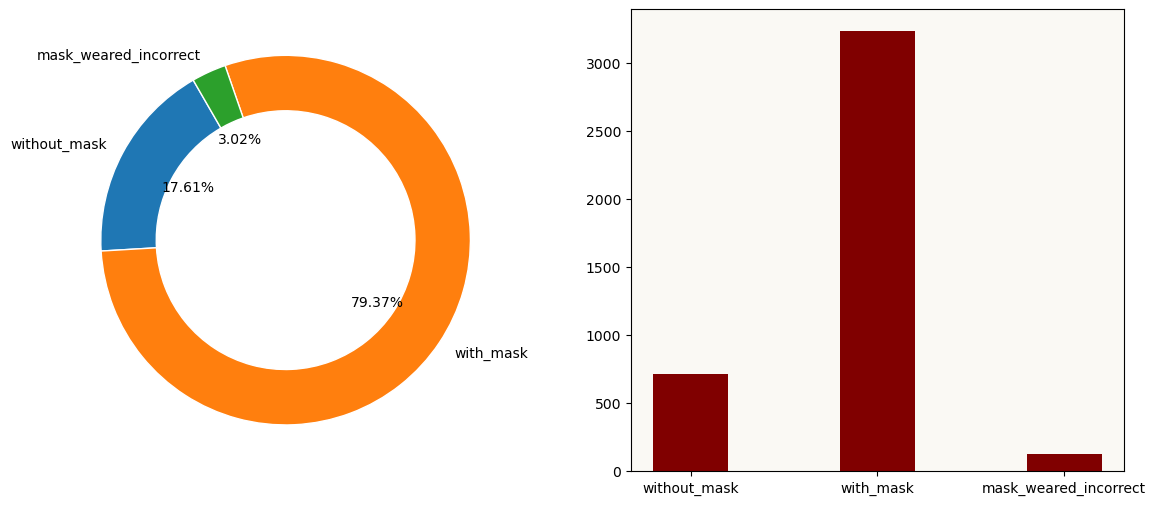

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()


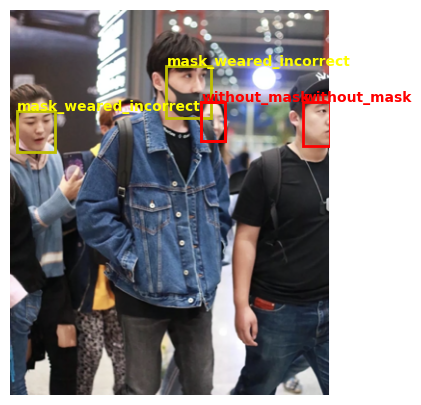

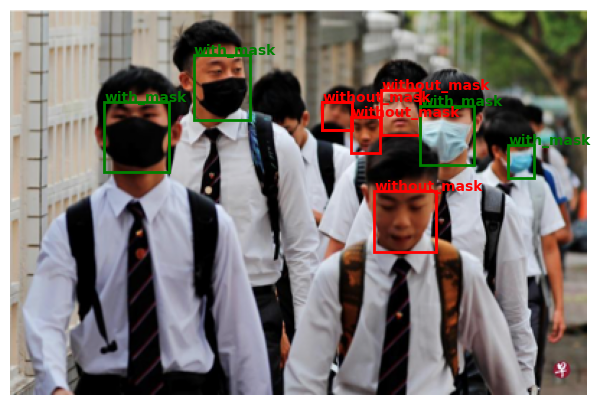

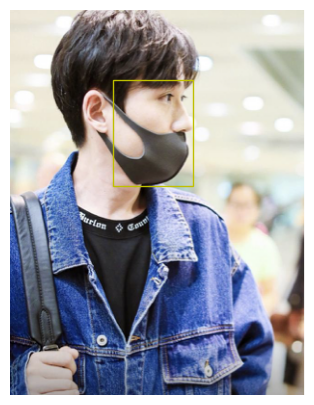

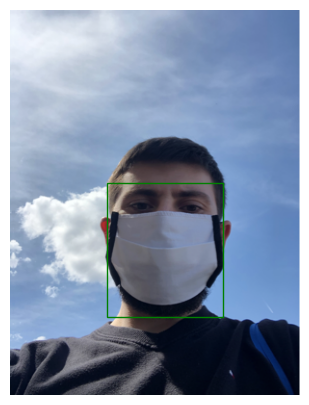

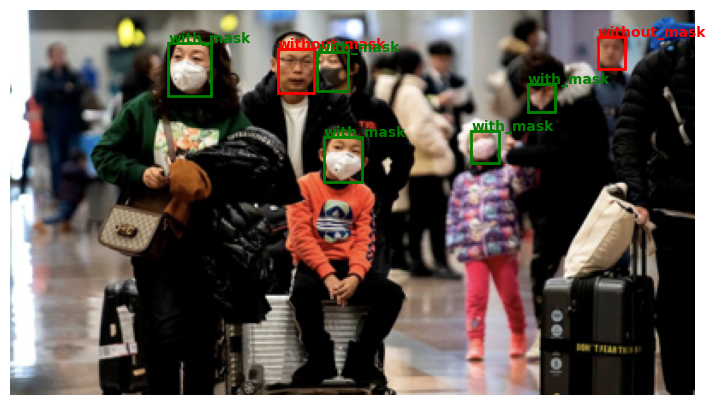

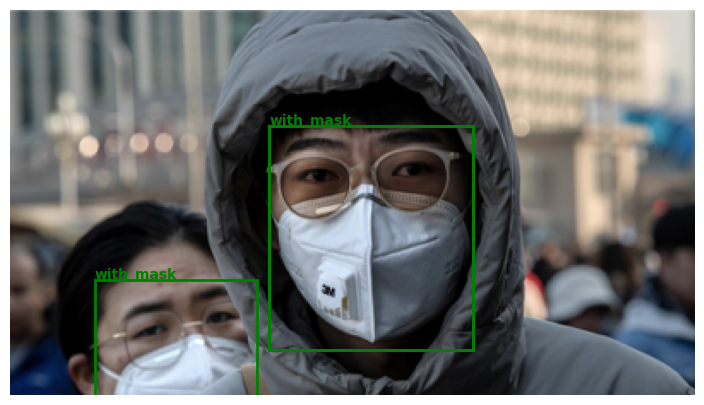

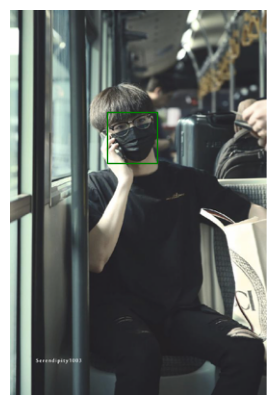

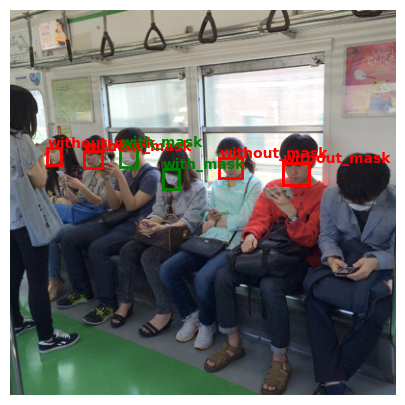

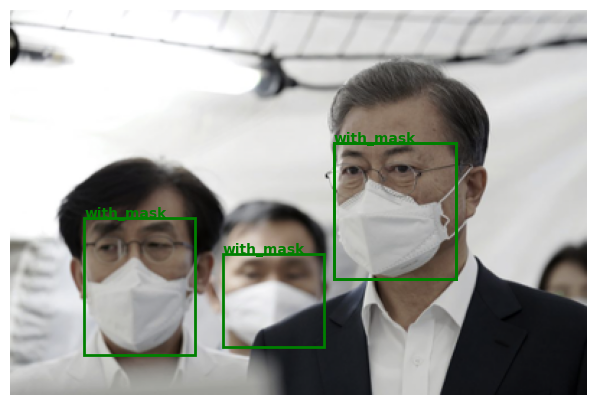

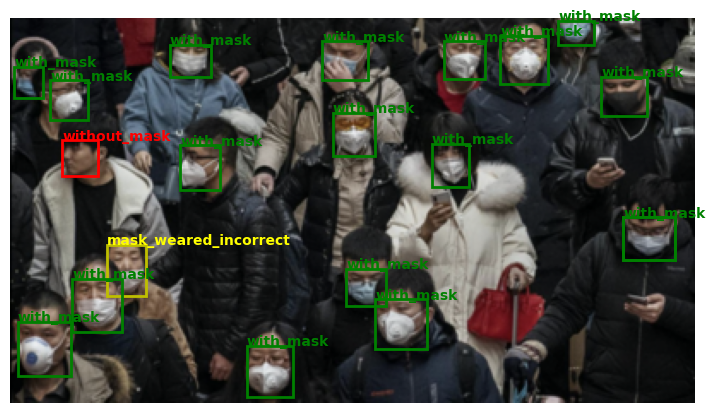

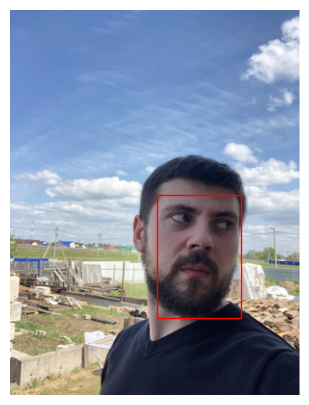

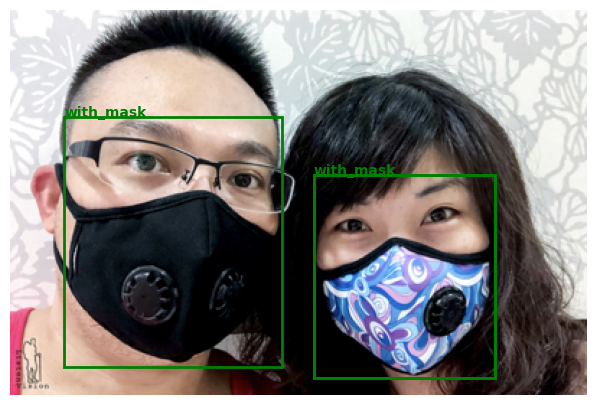

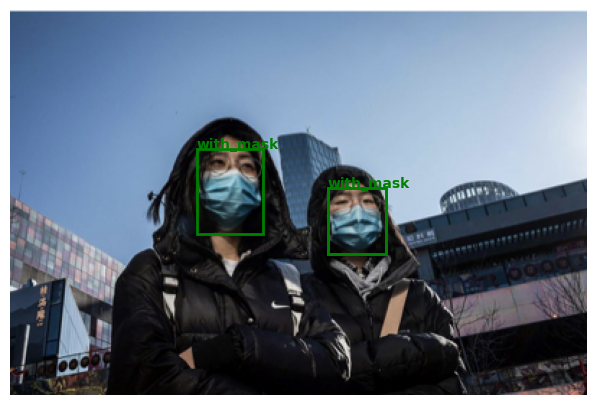

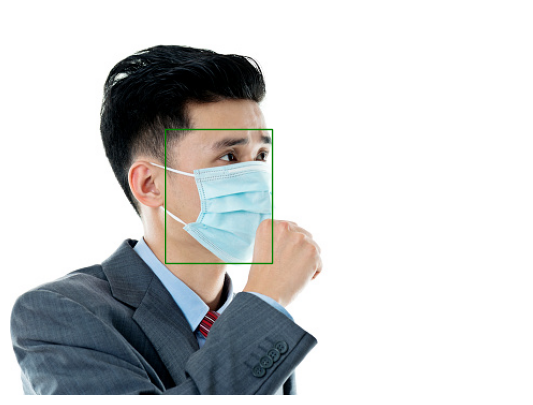

In [5]:
path_image="C:/Users/DHutc/Downloads/facemaskTraining/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(36, 50):
    face_cas(fun_images[i])

In [6]:
'''xmltodict.parse(xml_input, encoding='utf-8', expat=expat, process_namespaces=False, namespace_separator=':', **kwargs)
    *     **xml_input** : It can be a either be a string or a file-like object. Here we are using read() method, which reads at most n bytes from file desciptor and return a string containing the bytes read. If the end of file referred to by fd has been reached, an empty string is returned.
    *    **torchvision.transforms.Compose()** : torchvision.transforms is used for common image transformations and when Compose is chained with it to Compose several transforms together.
    *    **transforms.ToTensor()**: This just converts input image to PyTorch tensor.
    *    **torch.tensor()**:  It infers the dtype automatically. It always copies the data and torch.tensor(l) is equivalent to l.clone().detach().
    *    **transforms.Resize()** : The default interpolation is InterpolationMode.BILINEAR. It resize the input image as per the height and width provided. 
    *    **transforms.functional.crop()** : Crop the given image at specified location and output size and it returs torch.Tensor.'''

options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 

def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names)

Length of dataset is 4072 
Length of training set is : 3257 
Length of test set is : 815
Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


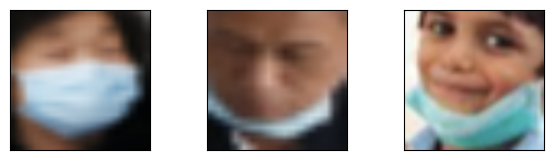

In [7]:
train_size=int(len(mydataset)*0.8)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

train_dataloader =DataLoader(dataset=trainset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader =DataLoader(dataset=testset,batch_size=32,shuffle=True,num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    
train_features_np=train_features.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(3):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))

In [8]:
import torch.nn as nn
out_features = 3

# resnet18
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
last_layer = nn.Linear(resnet18.fc.in_features, out_features)
resnet18.fc = last_layer

# resnet34
resnet34 = resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
last_layer  = nn.Linear(resnet34.fc.in_features, out_features)
resnet34.fc = last_layer

# resnet50
resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
last_layer  = nn.Linear(resnet50.fc.in_features, out_features)
resnet50.fc = last_layer

# alexnet
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet.classifier[4] = nn.Linear(4096, 1024)
last_layer  = nn.Linear(1024, out_features)
alexnet.classifier[6] = last_layer

# efficientnet
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
last_layer  = nn.Linear(1280, out_features)
efficientnet.classifier.fc = last_layer


Using cache found in C:\Users\DHutc/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\DHutc/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\DHutc/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\DHutc/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\DHutc/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [9]:
# Freeze model feature parameters, but keep classifier parameters trainable

resmodels = [resnet18, resnet34, resnet50]
classifiermodels = [alexnet, efficientnet]

for model in resmodels:
    # freeze model parameters with exception of fc layer
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

for model in classifiermodels:
    # freeze model parameters with exception of fc layer
    for param in model.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True

In [10]:
import torch.optim as optim
import matplotlib.pyplot as plt
def train(model, epochs):
    model.cuda()
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=0.001)
    epochs = 10
    n_epochs=epochs
    loss_vals = []
    for epoch in range(1,n_epochs+1):
        train_loss = 0.0
        epoch_loss=0.0

    ########################  TRAIN THE MODEL #################
        for batch,(data,target) in enumerate(train_dataloader):
        
        
            if torch.cuda.is_available():
                data , target = data.cuda(), target.cuda()
        
            optimizer.zero_grad()
            output=model(data)
            loss=criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            #if batch%20==19:
                #print("Epoch {}, batch {}, training loss {}".format(epoch, batch+1,train_loss/20))
            epoch_loss += train_loss
            train_loss = 0.0
        loss_vals.append(epoch_loss)
    return loss_vals
    


#########Testing##########
def test(model):
    criterion=nn.CrossEntropyLoss()

    test_loss=0.0
    acc=0
    model.eval()

    for data,target in test_dataloader:
        if torch.cuda.is_available():
            data,target=data.cuda(),target.cuda()
        output=model(data)
        loss=criterion(output,target)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        predicted=pred.numpy()[:,np.newaxis] if not torch.cuda.is_available() else pred.cpu().numpy()[:,np.newaxis]
        actual=target.numpy()[:,np.newaxis] if not torch.cuda.is_available() else target.cpu().numpy()[:,np.newaxis]
        acc+=np.sum(predicted==actual)/len(target.cpu().numpy())

    Average_loss=test_loss/len(test_dataloader)
    Average_acc=acc/len(test_dataloader)

    print("Avg total loss is {:.6f}".format(Average_loss))
    print("Avg accuracy is {:.6f}".format(Average_acc))

In [18]:
# Training
#print("Training ResNet18")
#res18_loss_sum = train(resnet18, 5)
# Save the model
torch.save(resnet18.state_dict(), 'resnet182.pth')
print("Testing ResNet18")
test(resnet18)

Testing ResNet18
Avg total loss is 0.184145
Avg accuracy is 0.931330


In [12]:
print("Training ResNet34")  
res34_loss_sum = train(resnet34, 5)
torch.save(resnet34.state_dict(), 'resnet342.pth')
print("Testing ResNet34")
test(resnet34)

Training ResNet34
Testing ResNet34
Avg total loss is 0.183505
Avg accuracy is 0.931330


In [17]:
#print("Training ResNet50")
#res50_loss_sum = train(resnet50, 5)
#torch.save(resnet50.state_dict(), 'resnet502.pth')
print("Testing ResNet50")
test(resnet50)

Testing ResNet50
Avg total loss is 0.216016
Avg accuracy is 0.927724


In [14]:
print("Training EfficientNet")
eff_loss_sum = train(efficientnet, 5)
torch.save(efficientnet.state_dict(), 'efficientnet2.pth')
print("Testing EfficientNet")
test(efficientnet)

Training EfficientNet
Testing EfficientNet
Avg total loss is 0.264726
Avg accuracy is 0.894071


In [15]:
print("Training AlexNet")
alex_loss_sum = train(alexnet, 5)
torch.save(alexnet.state_dict(), 'alexnet2.pth')
print("Testing AlexNet")
test(alexnet)

Training AlexNet
Testing AlexNet
Avg total loss is 0.219679
Avg accuracy is 0.915385


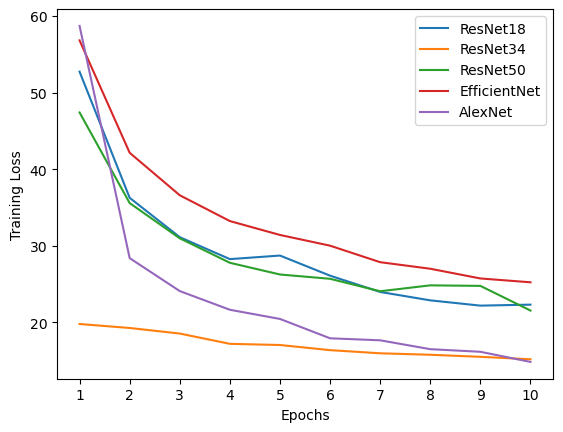

[52.737033009529114, 36.2692925632, 31.129408299922943, 28.265804044902325, 28.731577463448048, 26.104933202266693, 23.978608436882496, 22.88241959363222, 22.193608216941357, 22.32298019900918]
[19.794408194720745, 19.275179862976074, 18.54806486144662, 17.20535272359848, 17.053063984960318, 16.38155797496438, 15.970483060926199, 15.778386827558279, 15.50897665694356, 15.190241035073996]
[47.413825795054436, 35.58131396770477, 30.983033373951912, 27.78727798908949, 26.2584385946393, 25.697561837732792, 24.070318575948477, 24.842713102698326, 24.77056899294257, 21.552443098276854]
[56.82601362466812, 42.14881990849972, 36.60215836763382, 33.23357775807381, 31.41966912150383, 30.019543334841728, 27.86448873579502, 27.009821757674217, 25.741129830479622, 25.24008097499609]
[58.71282258629799, 28.39434875920415, 24.09355813637376, 21.65420539304614, 20.456111485138535, 17.928161716088653, 17.666260741651058, 16.508360600098968, 16.167344548157416, 14.843926639761776]


In [22]:
from matplotlib import pyplot as plt

# Plot all losses
plt.plot(res18_loss_sum, label='ResNet18')
plt.plot(res34_loss_sum, label='ResNet34')
plt.plot(res50_loss_sum, label='ResNet50')
plt.plot(eff_loss_sum, label='EfficientNet')
plt.plot(alex_loss_sum, label='AlexNet')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.xticks(range(0, 10), range(1, 11))
# add one to the x axis to start at 1
plt.legend()
plt.show()

print(res18_loss_sum)
print(res34_loss_sum)
print(res50_loss_sum)
print(eff_loss_sum)
print(alex_loss_sum)


In [ ]:
# count parameters
print(sum(p.numel() for p in resnet18.parameters()))
print(sum(p.numel() for p in resnet34.parameters()))
print(sum(p.numel() for p in resnet50.parameters()))
print(sum(p.numel() for p in efficientnet.parameters()))
print(sum(p.numel() for p in alexnet.parameters()))

21286211
21286211
23514179
4011391
44420931


In [ ]:
# Knowledge distillation
import torchdistill

student = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
last_layer = nn.Linear(resnet18.fc.in_features, out_features)
student.fc = last_layer
# load resnet50.pth
teacher = Model()
teacher.load_state_dict(torch.load('resnet50.pth'))
    

Using cache found in C:\Users\DHutc/.cache\torch\hub\pytorch_vision_v0.10.0


NameError: name 'Model' is not defined

In [ ]:
!python torchdistill/examples/legacy/image_classification.py --config torchdistill/configs/legacy/sample/cifar10/kd/resnet20_from_densenet_bc_k12_depth100-hyperparameter_tuning.yaml --log log/cifar10/kd/resnet20_from_densenet_bc_k12_depth100-hyperparameter_tuning.log